In [1]:

import numpy as np
import pandas as pd
from time import time
from IPython.display import display 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [2]:
# both the csv files are alredy combined
sales = pd.read_csv("sales_data.csv",encoding = "ISO-8859-1")
display(sales.head(n=5))


,transaction id,product id,product description,quantity sold,transaction timestamp,unit price,customer id,transaction country,date,day_name,day_of_month,month_of_year,time_of_day(hh:mm:ss)
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,01-12-2010,Wednesday,1,December,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,01-12-2010,Wednesday,1,December,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,01-12-2010,Wednesday,1,December,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,01-12-2010,Wednesday,1,December,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,01-12-2010,Wednesday,1,December,08:26:00


In [3]:
print(sales.shape)
sales.isnull().any()

(541909, 13)


transaction id           False
product id               False
product description       True
quantity sold            False
transaction timestamp    False
unit price               False
customer id               True
transaction country      False
date                     False
day_name                 False
day_of_month             False
month_of_year            False
time_of_day(hh:mm:ss)    False
dtype: bool

In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 13 columns):
transaction id           541909 non-null object
product id               541909 non-null object
product description      540455 non-null object
quantity sold            541909 non-null int64
transaction timestamp    541909 non-null object
unit price               541909 non-null float64
customer id              406829 non-null float64
transaction country      541909 non-null object
date                     541909 non-null object
day_name                 541909 non-null object
day_of_month             541909 non-null int64
month_of_year            541909 non-null object
time_of_day(hh:mm:ss)    541909 non-null object
dtypes: float64(2), int64(2), object(9)
memory usage: 53.7+ MB


In [5]:
#explore customer id which is missing 
print('percentage of customer id present:', ((406829/541909)*100))

percentage of customer id present: 75.0733056657114


In [6]:
#hence we can deleted the missing entries of customer id, as it is an important parameter to perform analysis
sales.dropna(axis = 0, subset = ['customer id'], inplace = True)
print(sales.isnull().sum())

transaction id           0
product id               0
product description      0
quantity sold            0
transaction timestamp    0
unit price               0
customer id              0
transaction country      0
date                     0
day_name                 0
day_of_month             0
month_of_year            0
time_of_day(hh:mm:ss)    0
dtype: int64


We have unit price and quantity sold, we can make a new column called revenue 

In [7]:
sales['revenue'] = sales['unit price'] * sales['quantity sold']

In [8]:
sales.describe()

,quantity sold,unit price,customer id,day_of_month,revenue
count,406829.000000,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,15.036128,20.401854
std,248.693370,69.315162,1713.600303,8.653730,427.591718
min,-80995.000000,0.000000,12346.000000,1.000000,-168469.600000
25%,2.000000,1.250000,13953.000000,7.000000,4.200000
50%,5.000000,1.950000,15152.000000,15.000000,11.100000
75%,12.000000,3.750000,16791.000000,22.000000,19.500000
max,80995.000000,38970.000000,18287.000000,31.000000,168469.600000


We have negative quanity sold, from observation we can see that negative quantity sold corresponds to cancelled orders

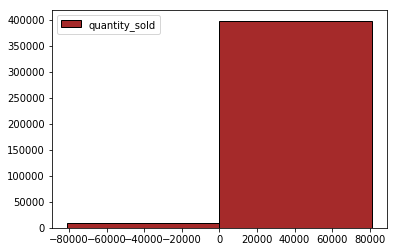

In [9]:
plt.hist(sales['quantity sold'], color = 'brown', edgecolor = 'black',label = 'quantity_sold',bins = 2)
plt.legend()

quantity sold is much higher than quantity cancelled

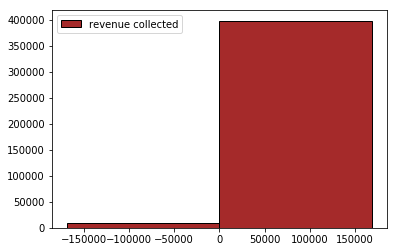

In [10]:
plt.hist(sales['revenue'], color = 'brown', edgecolor = 'black',label = 'revenue collected',bins = 2)
plt.legend()

In [11]:
quantity1 = sales[sales['quantity sold'] < 0]
cancel = quantity1.shape[0]
total = sales.shape[0]
print('percentage of orders canceled: ',cancel/total*100)

percentage of orders canceled:  2.188880340388714


In [12]:
country = sales[['transaction country', 'transaction id']]
country = country.pivot_table(columns='transaction country', aggfunc='count')
country.sort_values('transaction id', axis=1, ascending=False).T


,transaction id
transaction country,
United Kingdom,361878
Germany,9495
France,8491
EIRE,7485
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,1877
Portugal,1480


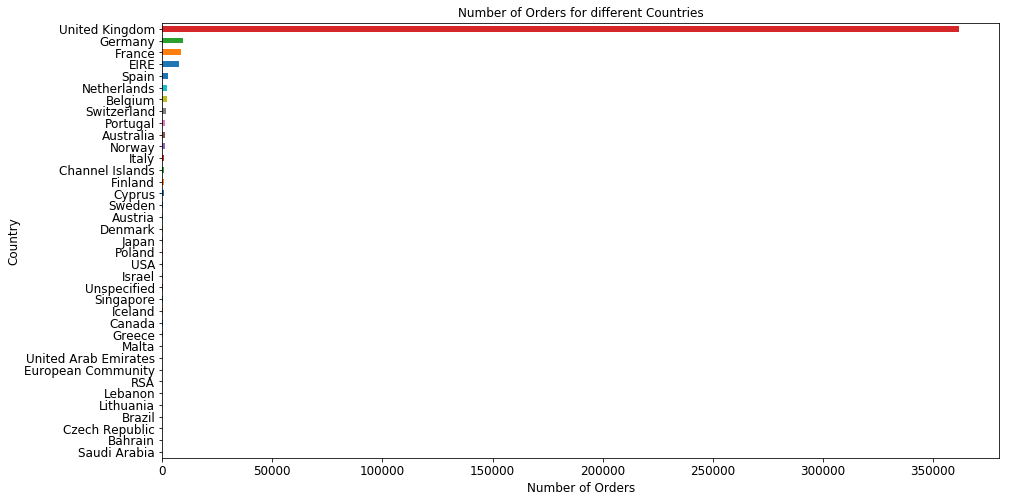

In [13]:
group_country_orders = sales.groupby('transaction country')['transaction id'].count().sort_values()
# del group_country_orders['United Kingdom']

plt.subplots(figsize=(15,8))
group_country_orders.plot('barh', fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

In [14]:
country = sales[['transaction country', 'revenue']]
country = country.pivot_table(columns='transaction country', aggfunc='sum')
country.sort_values('revenue', axis=1, ascending=False).T


,revenue
transaction country,
United Kingdom,6.767873e+06
Netherlands,2.846615e+05
EIRE,2.502852e+05
Germany,2.216982e+05
France,1.967128e+05
Australia,1.370773e+05
Switzerland,5.573940e+04
Spain,5.477458e+04
Belgium,4.091096e+04


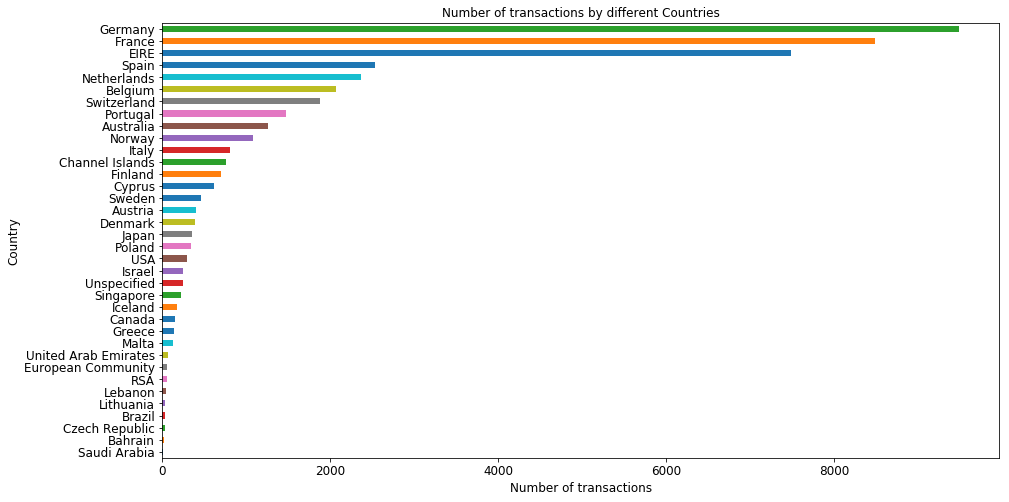

In [15]:
group_country_orders = sales.groupby('transaction country')['transaction id'].count().sort_values()
del group_country_orders['United Kingdom']

plt.subplots(figsize=(15,8))
group_country_orders.plot('barh', fontsize=12)
plt.xlabel('Number of transactions', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of transactions by different Countries', fontsize=12)
plt.show()

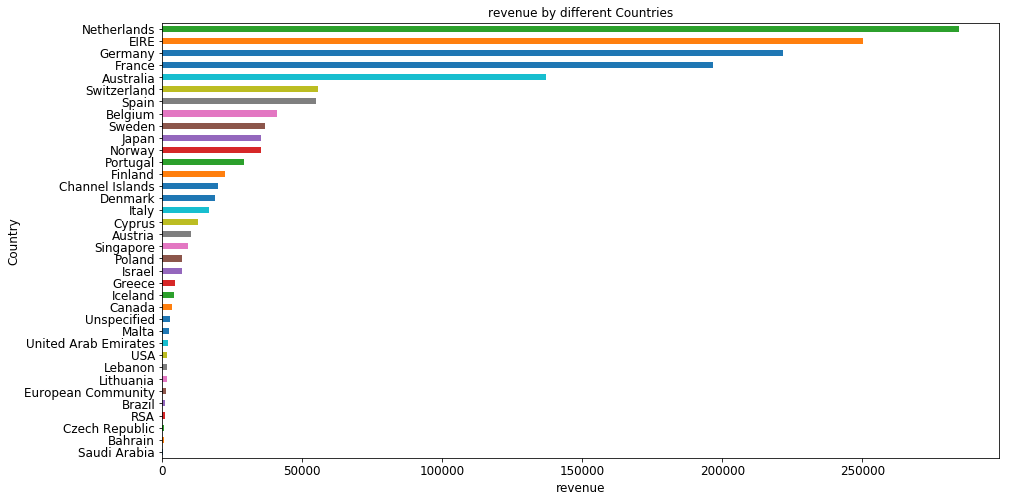

In [16]:
group_country_amount_spent = sales.groupby('transaction country')['revenue'].sum().sort_values()
del group_country_amount_spent['United Kingdom']

# plot total money spent by each country (without UK)
plt.subplots(figsize=(15,8))
group_country_amount_spent.plot('barh', fontsize=12)
plt.xlabel('revenue', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('revenue by different Countries', fontsize=12)
plt.show()

In [34]:
country = sales[['product description', 'revenue']]
country = country.pivot_table(columns='product description', aggfunc='sum')
country.sort_values('revenue', axis=1, ascending=False).T


,revenue
product description,
REGENCY CAKESTAND 3 TIER,132870.40
WHITE HANGING HEART T-LIGHT HOLDER,93823.85
JUMBO BAG RED RETROSPOT,83236.76
PARTY BUNTING,67687.53
POSTAGE,66710.24
ASSORTED COLOUR BIRD ORNAMENT,56499.22
RABBIT NIGHT LIGHT,51137.80
CHILLI LIGHTS,45936.81
PAPER CHAIN KIT 50'S CHRISTMAS,41500.48


In [35]:
country = sales[['product description', 'transaction id']]
country = country.pivot_table(columns='product description', aggfunc='count')
country.sort_values('transaction id', axis=1, ascending=False).T


,transaction id
product description,
WHITE HANGING HEART T-LIGHT HOLDER,2070
REGENCY CAKESTAND 3 TIER,1905
JUMBO BAG RED RETROSPOT,1662
ASSORTED COLOUR BIRD ORNAMENT,1418
PARTY BUNTING,1416
LUNCH BAG RED RETROSPOT,1358
SET OF 3 CAKE TINS PANTRY DESIGN,1232
POSTAGE,1196
LUNCH BAG BLACK SKULL.,1126


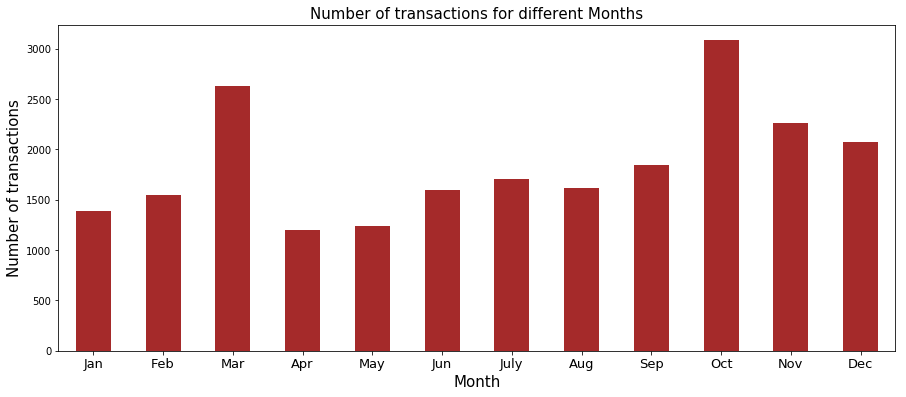

In [23]:
ax = sales.groupby('transaction id')['month_of_year'].unique().value_counts().sort_index().plot('bar',color = 'brown',figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of transactions',fontsize=15)
ax.set_title('Number of transactions for different Months',fontsize=15)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sep','Oct','Nov','Dec'), rotation='horizontal', fontsize=13)
plt.show()

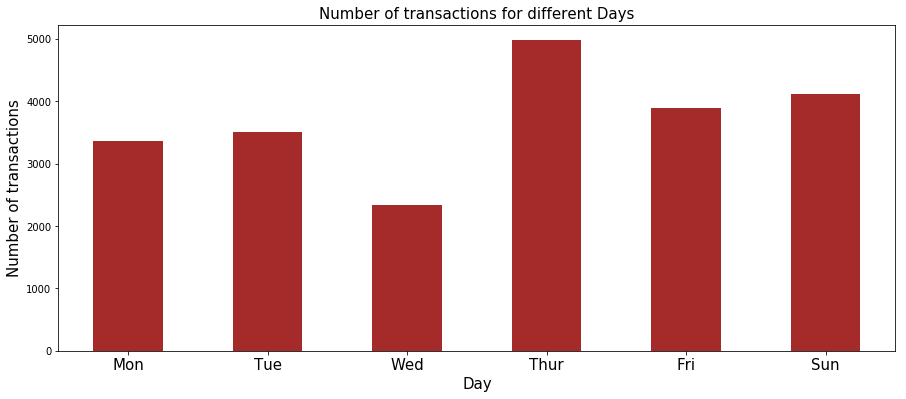

In [21]:
ax = sales.groupby('transaction id')['day_name'].unique().value_counts().sort_index().plot('bar',color='brown',figsize=(15,6))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of transactions',fontsize=15)
ax.set_title('Number of transactions for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

In [22]:
df = sales.copy(deep = True)

#Creating train and test set 
#Index 10392 marks the end of October 2013 
train=df[0:319992] 
test=df[319992:]
#Aggregating the dataset at daily level
df['Timestamp']= pd.to_datetime(df['transaction timestamp'],dayfirst = True)
df.index = df.Timestamp 
df = df.resample('D').mean()
train['Timestamp']= pd.to_datetime(train['transaction timestamp'],dayfirst = True)
train.index = train.Timestamp 
train = train.resample('D').mean() 
test['Timestamp']= pd.to_datetime(test['transaction timestamp'],dayfirst = True)
test.index = test.Timestamp 
test = test.resample('D').mean()


In [24]:
train1 = train.copy(deep = True)
test1 = test.copy(deep = True)
print(test.head())
print(train.shape)
print(test.shape)

            quantity sold  unit price   customer id  day_of_month    revenue
Timestamp                                                                   
2011-10-30       7.432184    2.595351  14851.427011          30.0  12.235563
2011-10-31       8.214908    4.338596  15092.076714          31.0  17.563917
2011-11-01       9.345434    2.951702  15470.959728           1.0  16.289966
2011-11-02      14.592098    2.734953  15773.435170           2.0  21.193890
2011-11-03      16.876382    3.041161  15432.503015           3.0  30.121568
(334, 5)
(41, 5)


In [25]:
train.dropna(axis = 0, inplace = True)
test.dropna(axis = 0, inplace = True)
df.dropna(axis = 0, inplace = True)

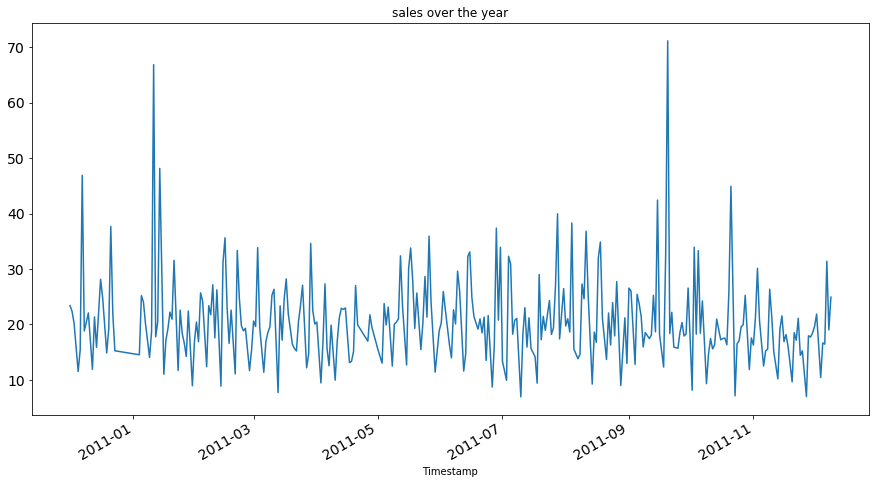

In [26]:
df.revenue.plot(figsize=(15,8), title= 'sales over the year', fontsize=14)

In [78]:
df.rename(columns={'quantity sold': 'quantity'}, inplace=True)
train.rename(columns={'quantity sold': 'quantity'}, inplace=True)
test.rename(columns={'quantity sold': 'quantity'}, inplace=True)
train1.rename(columns={'quantity sold': 'quantity'}, inplace=True)
test1.rename(columns={'quantity sold': 'quantity'}, inplace=True)
df.rename(columns={'unit price': 'unit_price'}, inplace=True)

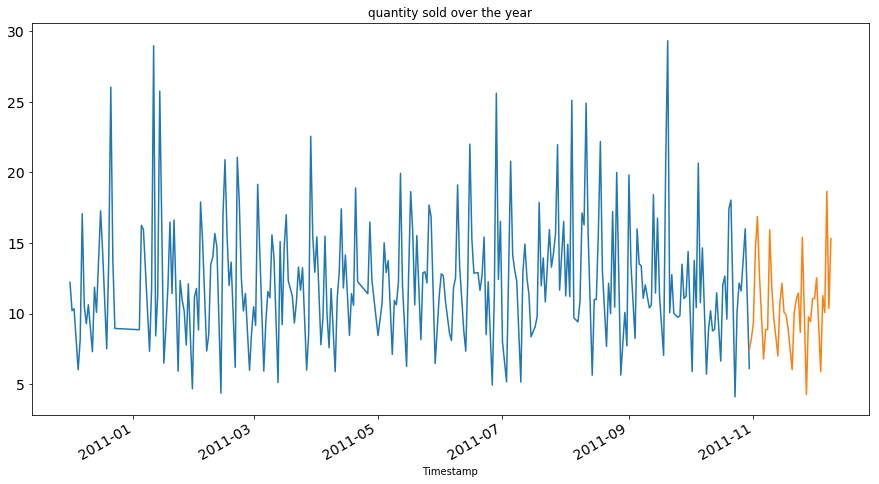

In [30]:
train.quantity.plot(figsize=(15,8), title= 'quantity sold over the year', fontsize=14)
test.quantity.plot(figsize=(15,8), title= 'quantity sold over the year', fontsize=14)
plt.show()


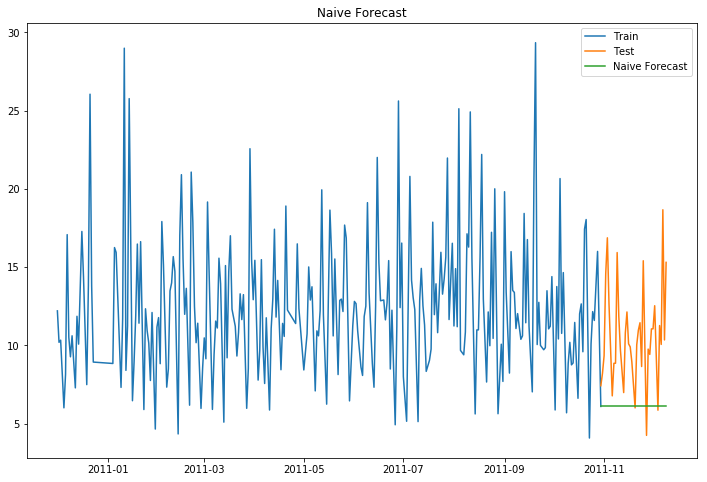

In [39]:
dd= np.asarray(train.quantity)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['quantity'], label='Train')
plt.plot(test.index,test['quantity'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [38]:
rms_rows = []
rms_index = []
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.quantity,y_hat.naive))
rms_rows.append(rms)
rms_index.append('Naive Forecast')

print(rms)

5.49017210267588


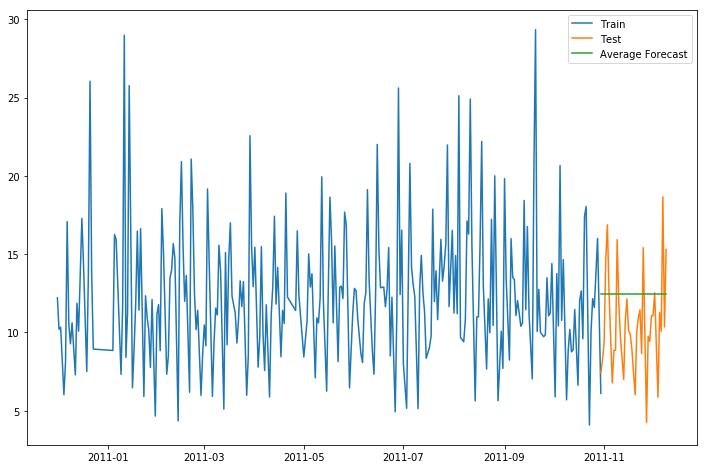

In [41]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['quantity'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()


In [43]:
rms = sqrt(mean_squared_error(test.quantity,y_hat_avg.avg_forecast))
print(rms)
rms_rows.append(rms)
rms_index.append('Average Forecast')


3.6464575288226304


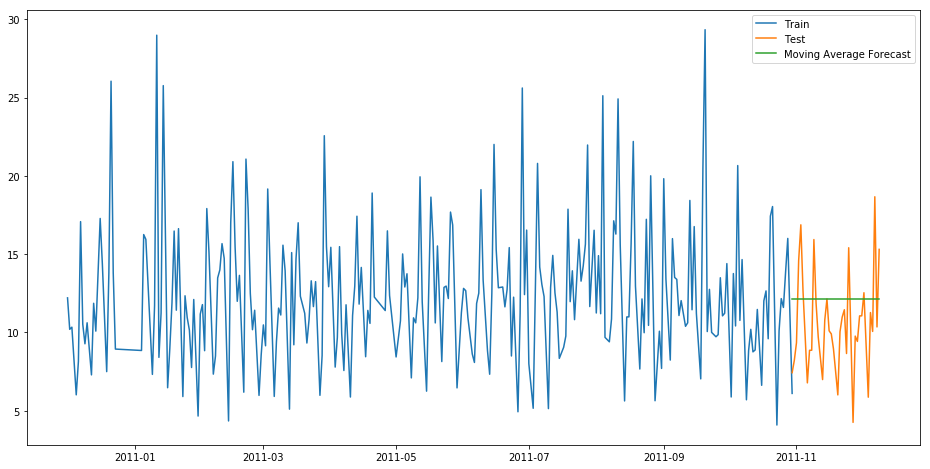

In [44]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['quantity'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [45]:
rms = sqrt(mean_squared_error(test.quantity,y_hat_avg.moving_avg_forecast))
print(rms)
rms_rows.append(rms)
rms_index.append('Moving Average Forecast')

3.4726598651174956


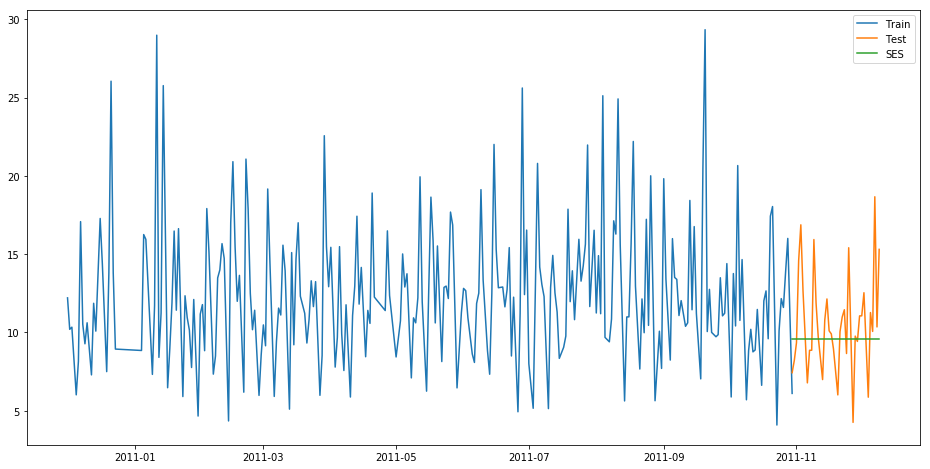

In [46]:

y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['quantity'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [47]:
rms = sqrt(mean_squared_error(test.quantity,y_hat_avg.SES))
print(rms)
rms_rows.append(rms)
rms_index.append('SES')

3.303178077774483


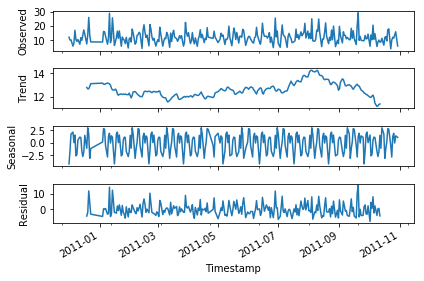

In [49]:
import statsmodels.api as sm
y=train['quantity']
sm.tsa.seasonal_decompose(train['quantity'],freq = 30).plot()
result = sm.tsa.stattools.adfuller(train.quantity)
plt.show()

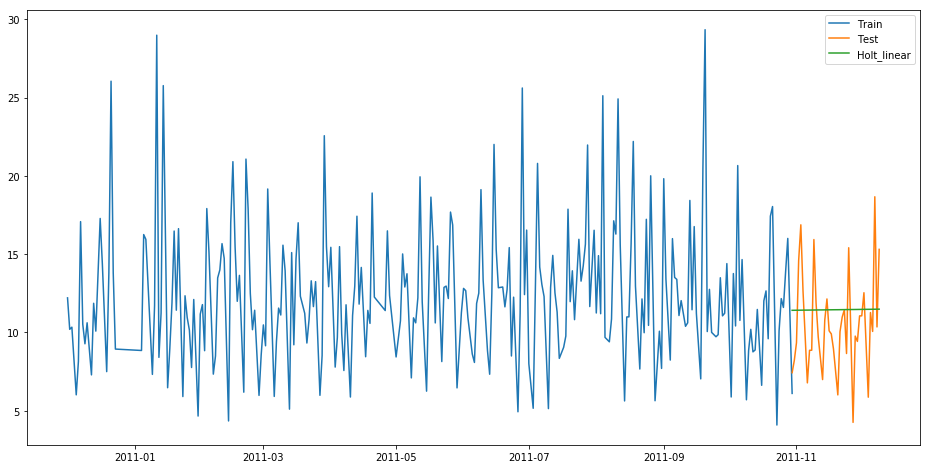

In [50]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['quantity'])).fit(smoothing_level =0.16,smoothing_slope = 0.0001)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [51]:
rms = sqrt(mean_squared_error(test.quantity,y_hat_avg.Holt_linear))
print(rms)
rms_rows.append(rms)
rms_index.append('Holt_linear')

3.239307494839936


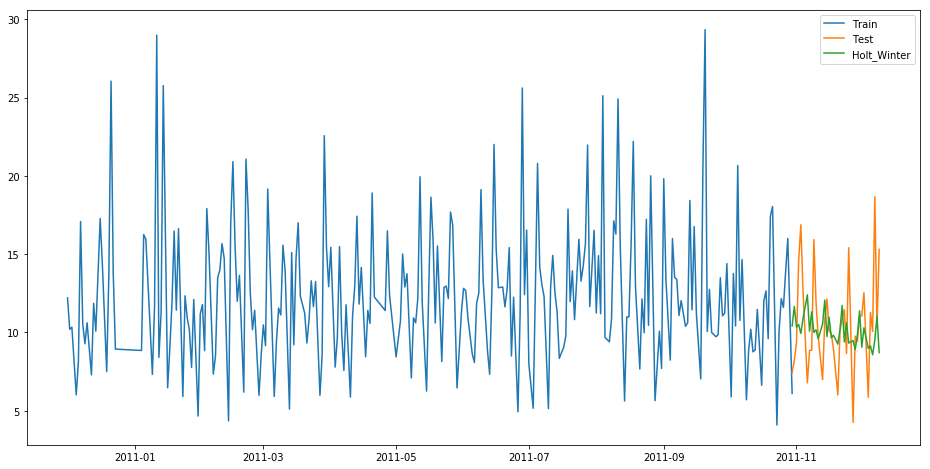

In [52]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['quantity']) ,seasonal_periods=7,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [53]:
rms = sqrt(mean_squared_error(test.quantity,y_hat_avg.Holt_Winter))
print(rms)
rms_rows.append(rms)
rms_index.append('Holt_winter')

3.441141627737717


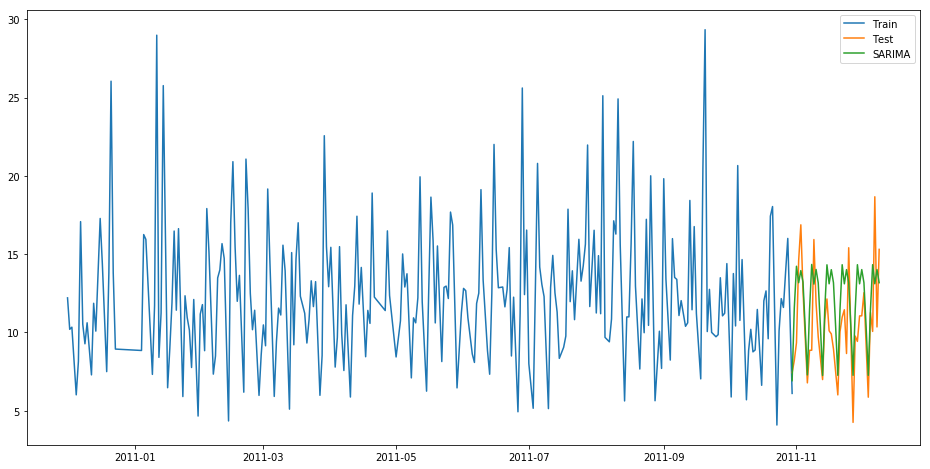

In [63]:
y_hat_avg = test1.copy()
fit1 = sm.tsa.statespace.SARIMAX(train1.quantity, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2011-10-30",end = "2011-12-30", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['quantity'], label='Train')
plt.plot(test['quantity'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [64]:
display(y_hat_avg.head())

,quantity,unit price,customer id,day_of_month,revenue,SARIMA
Timestamp,,,,,,
2011-10-30,7.432184,2.595351,14851.427011,30.0,12.235563,6.922694
2011-10-31,8.214908,4.338596,15092.076714,31.0,17.563917,11.574690
2011-11-01,9.345434,2.951702,15470.959728,1.0,16.289966,14.228641
2011-11-02,14.592098,2.734953,15773.435170,2.0,21.193890,13.179275
2011-11-03,16.876382,3.041161,15432.503015,3.0,30.121568,13.951368


In [65]:
test2 = test1.copy(deep = True)
comptest = y_hat_avg.copy(deep = True)

In [66]:
test2.dropna(axis = 0, inplace = True)
comptest.dropna(axis = 0, inplace = True)

In [67]:
print(test2.shape)
print(comptest.shape)

(36, 5)
(36, 6)


In [68]:
rms = sqrt(mean_squared_error(test2.quantity,comptest.SARIMA))
print(rms)
rms_rows.append(rms)
rms_index.append('ARIMA')

3.010583046984791


In [69]:
dataframe=pd.DataFrame(rms_rows,index=rms_index)   
dataframe.columns=['RMS error']
dataframe

,RMS error
Naive Forecast,5.490172
Average Forecast,3.646458
Moving Average Forecast,3.472660
SES,3.303178
Holt_linear,3.239307
Holt_winter,3.441142
ARIMA,3.010583


In [70]:
from apyori import apriori  

In [73]:
transactions = sales.groupby(sales['transaction id'])['product description'].unique()
print(transactions.head())

transaction id
536365    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
536366    [HAND WARMER UNION JACK, HAND WARMER RED POLKA...
536367    [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
536368    [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
536369                           [BATH BUILDING BLOCK WORD]
Name: product description, dtype: object


In [74]:
x= list(transactions)
print(len(x))
x = list(map(list,x))

22190


In [75]:
association_rules = apriori(x, min_support=0.0047, min_confidence=0.2, min_lift=3, min_length=2)  
association_results = list(association_rules) 

In [76]:
print(len(association_results)) 

1703


In [77]:
print(association_results[0]) 

RelationRecord(items=frozenset({'12 PENCILS SMALL TUBE RED RETROSPOT', '12 PENCIL SMALL TUBE WOODLAND'}), support=0.004957187922487607, ordered_statistics=[OrderedStatistic(items_base=frozenset({'12 PENCIL SMALL TUBE WOODLAND'}), items_add=frozenset({'12 PENCILS SMALL TUBE RED RETROSPOT'}), confidence=0.39568345323741005, lift=28.232205232598485), OrderedStatistic(items_base=frozenset({'12 PENCILS SMALL TUBE RED RETROSPOT'}), items_add=frozenset({'12 PENCIL SMALL TUBE WOODLAND'}), confidence=0.3536977491961415, lift=28.23220523259849)])
